In [1]:
import pandas as pd
df = pd.read_csv("dataset/20230817/all-word-feature-20230817-125.csv")
df.head()

,exp_id,word,word_understand,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff
0,585,A,1,0,0,0,0.0,0.0,0,0,0
1,585,judge,1,1,3,927,927.0,185.4,927,3,1
2,585,in,1,1,1,245,245.0,122.5,-682,-2,0
3,585,the,1,0,0,0,0.0,0.0,-245,-1,-1
4,585,US,1,1,1,321,321.0,160.5,321,1,1


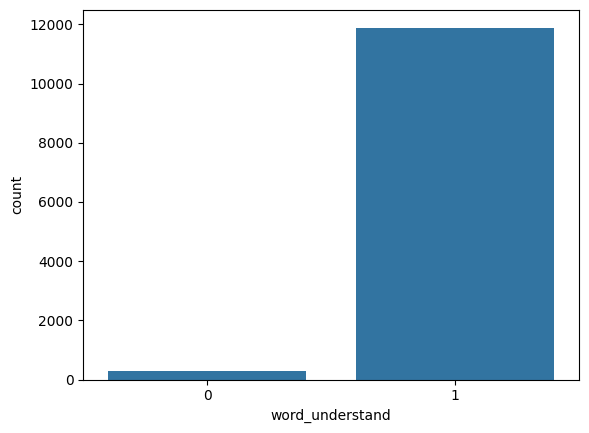

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 例如，绘制柱状图查看不同类别的数量分布
sns.countplot(x='word_understand', data=df)
plt.show()

In [3]:
# 模型与预测

In [4]:
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


class PredictAndEvalute:
    def __init__(self, df, use_word):
        self.df = df
        self.df['word'] = self.df['word'].apply(self.clean_text)
        self.X = self.df.drop(['word_understand','word'], axis=1)  # 特征集
        self.y = self.df['word_understand']  # 目标变量
        self.use_word = use_word
        

    def clean_text(self, text):
        text = re.sub(r'[^\w\s]', '', text)  # 去除标点符号
        text = text.lower()  # 转换为小写
        return text

    def text_to_vector(self):
        # 初始化词袋模型
        vectorizer = CountVectorizer()
        # 对文本列进行向量化
        X_word = vectorizer.fit_transform(self.df['word'])
        # 将稀疏矩阵转换为稠密矩阵（如果需要）
        X_word = X_word.toarray()
        # 将得到的向量化特征拼接到原始特征中
        self.X = np.concatenate((X_word, self.df.drop(['word', 'word_understand'], axis=1).values), axis=1)
    
    def predict(self):
        if self.use_word:
            self.text_to_vector()
        # 划分数据集
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # 取正类的概率
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC: {auc_score}")



In [5]:
allDataModel = PredictAndEvalute(df, False)
allDataModel.predict()

              precision    recall  f1-score   support

           0       0.48      0.11      0.18        88
           1       0.98      1.00      0.99      3564

    accuracy                           0.98      3652
   macro avg       0.73      0.56      0.59      3652
weighted avg       0.97      0.98      0.97      3652

AUC: 0.877037419651056


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
# 拆分跳读与非跳读数据

In [7]:
# 按照 exp_id 进行分组，并对其他列进行聚合操作
aggregated_df = df.groupby('exp_id').agg({
    'reading_times': 'sum',         # 其他数值型特征可以选择求和、平均值等操作
    'number_of_fixations': 'sum',
    'fixation_duration': 'sum',
    'fixation_duration_div_syllable': 'sum',
    'fixation_duration_div_length': 'sum',
    'fixation_duration_diff': 'sum',
    'number_of_fixations_diff': 'sum',
    'reading_times_diff': 'sum'
}).reset_index()

# 查看聚合后的数据
print(aggregated_df)

    exp_id  reading_times  number_of_fixations  fixation_duration  \
0      585            211                  300             109705   
1      590            259                  340             129146   
2      597            246                  314             124564   
3      598            377                  507             208897   
4      630            427                  594             235581   
5      641            336                  442             161023   
6      902            181                  219              71207   
7      903            320                  426             144789   
8      904            273                  335             111995   
9      941            219                  283              96431   
10     962            196                  239              84500   
11     965            356                  521             202019   
12     970            408                  560             220356   
13     972            196         

In [8]:
# 按照 fixation_duration 列降序排序，并选择只显示 exp_id 列
sorted_exp_ids = aggregated_df.sort_values(by='fixation_duration', ascending=False)['exp_id']
lens = int(len(sorted_exp_ids) * 0.8)
not_skip_ids = sorted_exp_ids[:lens]
skip_ids = sorted_exp_ids[lens:len(sorted_exp_ids)]
# 打印排序后的 exp_id
print(len(not_skip_ids))
print(not_skip_ids)

26
20    1073
4      630
21    1074
12     970
19    1072
3      598
11     965
22    1090
18    1071
23    1091
5      641
24    1129
14    1011
27    1144
7      903
15    1014
1      590
2      597
8      904
31    1151
0      585
13     972
29    1146
28    1145
30    1149
9      941
Name: exp_id, dtype: int64


In [9]:
not_skip_data = df[df['exp_id'].isin(not_skip_ids)]
not_skip_data

,exp_id,word,word_understand,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff
0,585,a,1,0,0,0,0.0,0.0,0,0,0
1,585,judge,1,1,3,927,927.0,185.4,927,3,1
2,585,in,1,1,1,245,245.0,122.5,-682,-2,0
3,585,the,1,0,0,0,0.0,0.0,-245,-1,-1
4,585,us,1,1,1,321,321.0,160.5,321,1,1
...,...,...,...,...,...,...,...,...,...,...,...
11859,1151,be,1,0,0,0,0.0,0.0,0,0,0
11860,1151,specified,1,0,0,0,0.0,0.0,0,0,0
11861,1151,in,1,0,0,0,0.0,0.0,0,0,0
11862,1151,computational,1,0,0,0,0.0,0.0,0,0,0


In [10]:
skip_data = df[df['exp_id'].isin(skip_ids)]
skip_data

,exp_id,word,word_understand,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff
2302,902,senior,1,0,0,0,0.000000,0.000000,0,0,0
2303,902,iranian,1,1,1,215,71.666667,30.714286,215,1,1
2304,902,figures,1,0,0,0,0.000000,0.000000,-215,-1,-1
2305,902,have,1,1,2,818,818.000000,204.500000,818,2,1
2306,902,expressed,1,1,1,292,146.000000,32.444444,-526,-1,0
...,...,...,...,...,...,...,...,...,...,...,...
12167,1156,enough,1,0,0,0,0.000000,0.000000,0,0,0
12168,1156,to,1,0,0,0,0.000000,0.000000,0,0,0
12169,1156,deflect,0,0,0,0,0.000000,0.000000,0,0,0
12170,1156,its,1,0,0,0,0.000000,0.000000,0,0,0


In [11]:
sequenceDataModel = PredictAndEvalute(not_skip_data, False)
sequenceDataModel.predict()

/tmp/ipykernel_112942/1488859566.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['word'] = self.df['word'].apply(self.clean_text)


              precision    recall  f1-score   support

           0       0.53      0.17      0.26        52
           1       0.99      1.00      0.99      2924

    accuracy                           0.98      2976
   macro avg       0.76      0.59      0.63      2976
weighted avg       0.98      0.98      0.98      2976

AUC: 0.8667262969588551


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
skipDataModel = PredictAndEvalute(skip_data, False)
skipDataModel.predict()

/tmp/ipykernel_112942/1488859566.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['word'] = self.df['word'].apply(self.clean_text)


              precision    recall  f1-score   support

           0       0.67      0.08      0.15        24
           1       0.97      1.00      0.98       653

    accuracy                           0.97       677
   macro avg       0.82      0.54      0.57       677
weighted avg       0.96      0.97      0.95       677

AUC: 0.8219754977029097


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
skip_data = pd.read_csv('skip_data_predict.csv')
recall_data = skip_data[(skip_data['predicted_label']==1)&(skip_data['true_label']==0)]
pd.set_option('display.max_rows', 15)
recall_data


,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,word,predicted_label,true_label
10,902,2,3,821,410.50,117.285714,821,3,2,custody,1,0
36,902,0,0,0,0.00,0.000000,0,0,0,probe,1,0
49,902,1,2,949,237.25,94.900000,725,1,0,repetition,1,0
63,902,1,1,501,501.00,83.500000,501,1,1,jailed,1,0
159,902,0,0,0,0.00,0.000000,-991,-3,-3,assaulted,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2192,1156,1,2,791,395.50,87.888889,191,1,0,scuffling,1,0
2203,1156,2,2,1073,1073.00,214.600000,499,1,1,probe,1,0
2206,1156,1,2,642,214.00,80.250000,642,2,1,asteroid,1,0
2223,1156,3,4,1691,845.50,241.571429,1424,3,2,sizable,1,0


In [10]:
skip_data.describe()

,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,predicted_label,true_label
count,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.000000,2255.00000,2255.000000,2255.000000
mean,1056.703326,0.546785,0.698004,229.416408,160.115795,48.685261,-0.419512,-0.000887,-0.00133,0.991574,0.968071
std,86.425149,0.658308,0.932348,330.376007,236.488743,76.284467,435.941336,1.213646,0.81332,0.091424,0.175850
min,902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2662.000000,-5.000000,-3.00000,0.000000,0.000000
25%,962.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-214.500000,-1.000000,0.00000,1.000000,1.000000
50%,1062.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
75%,1132.000000,1.000000,1.000000,383.500000,247.000000,74.976190,215.000000,1.000000,0.00000,1.000000,1.000000
max,1156.000000,4.000000,7.000000,2662.000000,1760.000000,584.500000,2222.000000,7.000000,4.00000,1.000000,1.000000


In [33]:
skip_predict = skip_data[skip_data['predicted_label']==0]
skip_predict.describe()

,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,predicted_label,true_label
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.000000
mean,1026.052632,1.947368,4.315789,1674.947368,607.707895,167.995609,1407.210526,3.578947,1.315789,0.0,0.526316
std,88.668843,0.779864,1.204281,392.163865,298.788773,63.780574,528.766970,1.502435,1.002920,0.0,0.512989
min,902.000000,1.000000,2.000000,1124.000000,244.200000,81.400000,293.000000,1.000000,0.000000,0.0,0.000000
25%,962.000000,1.500000,3.500000,1413.500000,407.750000,118.214286,1161.500000,2.500000,1.000000,0.0,0.000000
50%,1055.000000,2.000000,4.000000,1608.000000,504.666667,148.909091,1400.000000,4.000000,1.000000,0.0,1.000000
75%,1131.000000,2.000000,5.000000,1847.500000,779.333333,224.437500,1821.000000,4.000000,2.000000,0.0,1.000000
max,1132.000000,4.000000,7.000000,2662.000000,1331.000000,295.777778,2222.000000,7.000000,4.000000,0.0,1.000000


In [34]:
skip_predict = skip_data[skip_data['true_label']==0]
skip_predict.describe()

,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,predicted_label,true_label
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.00000,72.0
mean,1070.805556,1.083333,1.902778,719.500000,313.301852,86.126754,433.152778,1.083333,0.444444,0.87500,0.0
std,91.687411,0.851676,1.712915,620.121864,320.630676,79.215655,714.478982,1.941032,1.033099,0.33304,0.0
min,902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1386.000000,-3.000000,-3.000000,0.00000,0.0
25%,1031.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.0
50%,1130.000000,1.000000,2.000000,714.500000,228.375000,77.833333,398.500000,1.000000,0.500000,1.00000,0.0
75%,1156.000000,2.000000,3.000000,1074.000000,501.916667,134.812500,832.750000,2.000000,1.000000,1.00000,0.0
max,1156.000000,3.000000,6.000000,2202.000000,1399.000000,304.666667,1990.000000,6.000000,2.000000,1.00000,0.0


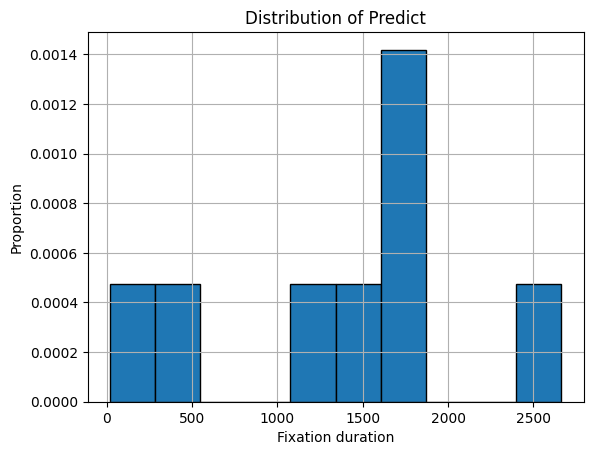

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming skip_predict is your DataFrame and 'fixation_duration' is the column you want to plot
data = skip_predict['fixation_duration']

# Plotting the histogram
plt.hist(data, bins=10, edgecolor='black', density=True)  # density=True makes the y-axis show proportions
plt.xlabel('Fixation duration')
plt.ylabel('Proportion')
plt.title('Distribution of Predict')
plt.grid(True)
plt.show()


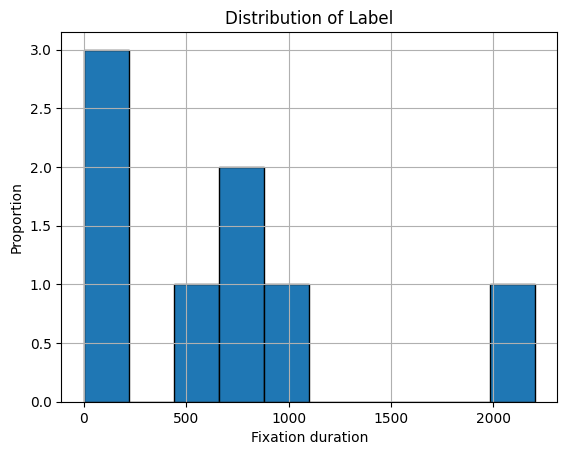

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming skip_predict is your DataFrame and 'fixation_duration' is the column you want to plot
data = true_label['fixation_duration']

# Plotting the histogram
plt.hist(data, bins=10, edgecolor='black')  # density=True makes the y-axis show proportions
plt.xlabel('Fixation duration')
plt.ylabel('Proportion')
plt.title('Distribution of Label')
plt.grid(True)
plt.show()


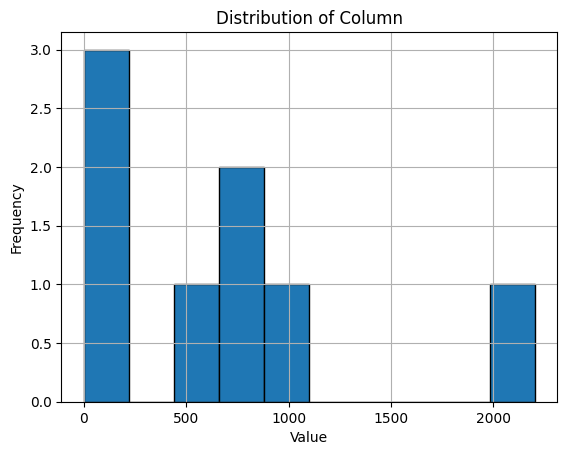

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

plt.hist(true_label['fixation_duration'], bins=10, edgecolor='black')  # 'column_name' 替换为你想要绘制的列名
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Column')
plt.grid(True)
plt.show()

In [13]:
true_label = skip_data[skip_data['true_label']==0].describe()

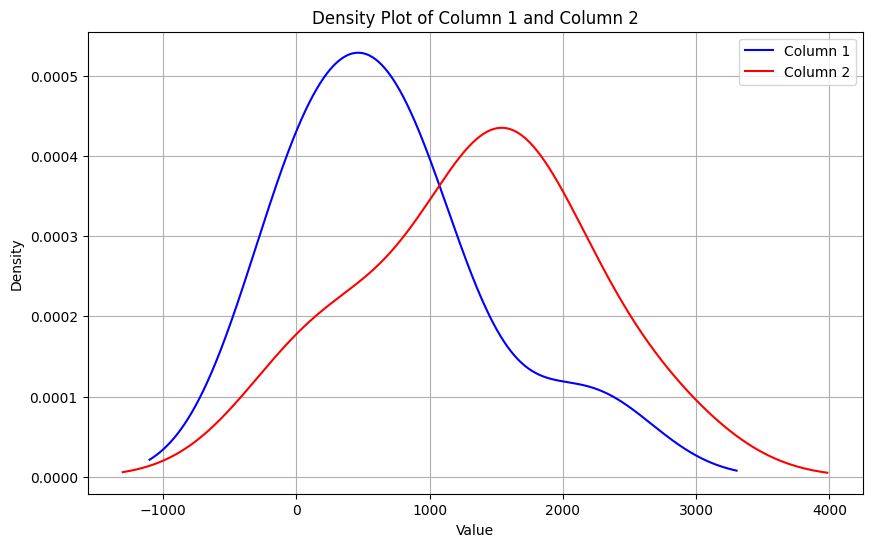

In [17]:
# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制第一列数据的密度估计图
true_label['fixation_duration'].plot.kde(label='Column 1', color='blue')

# 绘制第二列数据的密度估计图
skip_predict['fixation_duration'].plot.kde(label='Column 2', color='red')

# 添加标题和标签
plt.title('Density Plot of Column 1 and Column 2')
plt.xlabel('Value')
plt.ylabel('Density')

# 添加网格
plt.grid(True)

# 添加图例
plt.legend()

# 显示图形
plt.show()


In [21]:
not_skip_data.describe()

,exp_id,word_understand,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff
count,9917.00000,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000
mean,946.95059,0.978824,0.795604,1.082585,413.337199,283.053554,87.667953,-1.630634,-0.004134,-0.002924
std,199.06640,0.143977,0.810672,1.258507,540.532385,373.974226,122.937952,670.333390,1.554666,0.902068
min,585.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5883.000000,-10.000000,-6.000000
25%,903.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-321.000000,-1.000000,-1.000000
50%,1011.00000,1.000000,1.000000,1.000000,247.000000,208.000000,56.000000,0.000000,0.000000,0.000000
75%,1091.00000,1.000000,1.000000,2.000000,610.000000,418.000000,124.166667,301.000000,1.000000,1.000000
max,1151.00000,1.000000,12.000000,17.000000,8456.000000,7501.000000,3149.000000,6550.000000,11.000000,7.000000


In [13]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

class PredictAndEvalute:
    def __init__(self, df, use_word):
        self.df = df
        self.df['word'] = self.df['word'].apply(self.clean_text)
        self.X = self.df.drop(['word_understand','word'], axis=1)  # Features
        self.y = self.df['word_understand']  # Target variable
        self.use_word = use_word

    def clean_text(self, text):
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.lower()  # Convert to lowercase
        return text

    def text_to_vector(self):
        # Initialize CountVectorizer
        vectorizer = CountVectorizer()
        # Vectorize text column
        X_word = vectorizer.fit_transform(self.df['word'])
        # Convert sparse matrix to dense matrix if needed
        X_word = X_word.toarray()
        # Concatenate vectorized features with original features
        self.X = np.concatenate((X_word, self.df.drop(['word', 'word_understand'], axis=1).values), axis=1)

    def predict_and_save(self, output_file='predicted_results.csv'):
        if self.use_word:
            self.text_to_vector()

        # Split dataset into train and test
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)

        # Initialize Logistic Regression model
        model = LogisticRegression()

        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Predict classes for the test set
        y_pred = model.predict(X_test)

        # Print classification report
        print(classification_report(y_test, y_pred))

        # Calculate and print AUC score
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC: {auc_score}")

        # Prepare DataFrame with original features, labels, predicted labels, and probabilities
        results_df = X_test
        results_df['y_pred'] = y_pred.tolist()
        results_df['y_label'] = y_test.tolist()
        

        # Save results to CSV
        results_df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")


In [14]:
model = PredictAndEvalute(not_skip_data, False)
model.predict_and_save()

/tmp/ipykernel_48938/4095982598.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['word'] = self.df['word'].apply(self.clean_text)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.53      0.17      0.26        52
           1       0.99      1.00      0.99      2924

    accuracy                           0.98      2976
   macro avg       0.76      0.59      0.63      2976
weighted avg       0.98      0.98      0.98      2976

AUC: 0.8667262969588551
Predictions saved to predicted_results.csv


In [2]:
import pandas as pd
not_skip_predict = pd.read_csv('not_skip_predicted.csv')

In [3]:
not_skip_predict.describe()

,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,y_pred,y_label
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,941.254368,0.775202,1.043347,396.212366,270.377434,85.443627,-22.347446,-0.044019,-0.027218,0.994288,0.982527
std,201.820673,0.807655,1.251206,530.318817,356.815832,127.509678,660.339373,1.517986,0.891943,0.075377,0.131048
min,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5883.000000,-8.000000,-4.000000,0.000000,0.000000
25%,903.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-322.250000,-1.000000,-1.000000,1.000000,1.000000
50%,1011.000000,1.000000,1.000000,234.500000,204.000000,53.535714,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1091.000000,1.000000,2.000000,587.000000,394.125000,119.312500,270.000000,1.000000,1.000000,1.000000,1.000000
max,1151.000000,7.000000,12.000000,5112.000000,3605.000000,3149.000000,4806.000000,11.000000,4.000000,1.000000,1.000000


In [4]:
not_skip_predict[(not_skip_predict['y_pred']==0)].describe()

,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,y_pred,y_label
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.000000
mean,987.470588,2.764706,7.294118,3484.058824,1014.520168,340.674930,2489.352941,4.705882,1.058824,0.0,0.470588
std,154.685616,1.855041,2.710275,871.344613,463.909543,132.720634,1272.498229,3.477871,1.390620,0.0,0.514496
min,597.000000,1.000000,3.000000,2047.000000,511.750000,146.631579,-446.000000,-2.000000,-1.000000,0.0,0.000000
25%,965.000000,1.000000,5.000000,2905.000000,726.250000,268.071429,2047.000000,2.000000,0.000000,0.0,0.000000
50%,1073.000000,2.000000,8.000000,3347.000000,871.333333,290.909091,2503.000000,5.000000,1.000000,0.0,0.000000
75%,1074.000000,4.000000,9.000000,3925.000000,1308.333333,437.600000,3347.000000,6.000000,2.000000,0.0,1.000000
max,1091.000000,7.000000,12.000000,5112.000000,2188.000000,635.428571,4806.000000,11.000000,4.000000,0.0,1.000000


In [38]:
not_skip_predict[(not_skip_predict['y_label']==0)].describe()

,exp_id,reading_times,number_of_fixations,fixation_duration,fixation_duration_div_syllable,fixation_duration_div_length,fixation_duration_diff,number_of_fixations_diff,reading_times_diff,y_pred,y_label
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.0
mean,966.173077,1.461538,3.230769,1446.730769,533.219734,152.681465,944.192308,1.846154,0.403846,0.826923,0.0
std,190.308596,1.092964,2.548474,1064.734527,440.291043,111.343741,1129.114715,2.689009,1.224899,0.382005,0.0
min,585.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1466.000000,-5.000000,-4.000000,0.000000,0.0
25%,903.000000,1.000000,1.000000,789.000000,204.312500,77.525000,217.000000,0.000000,0.000000,1.000000,0.0
50%,1012.500000,1.000000,3.000000,1393.000000,467.250000,137.611111,808.000000,1.500000,0.000000,1.000000,0.0
75%,1100.500000,2.000000,4.250000,1926.500000,715.375000,213.694444,1415.250000,3.000000,1.000000,1.000000,0.0
max,1151.000000,6.000000,12.000000,5071.000000,1958.000000,563.444444,4806.000000,11.000000,4.000000,1.000000,0.0
